In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


### Reading cell2location model output

In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [3]:
# annotate region clusters
region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)
region_annot.index.name = 'region_cluster'
region_annot = region_annot.reindex(index = list(adata_vis.obs['region_cluster']))
region_annot.index = adata_vis.obs_names

adata_vis.obs[region_annot.columns] = region_annot

In [4]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'region_final' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'comments' as categorical


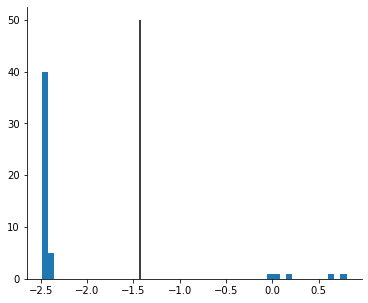

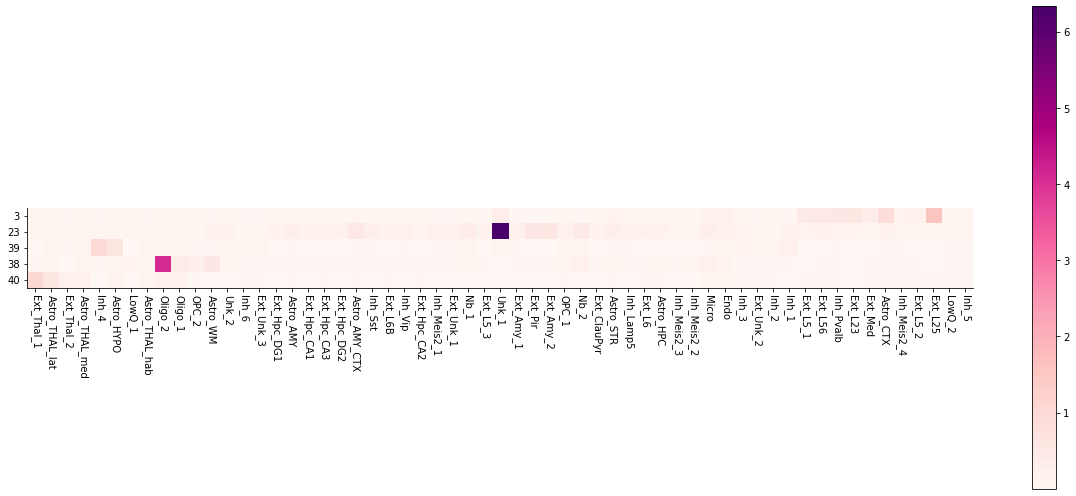

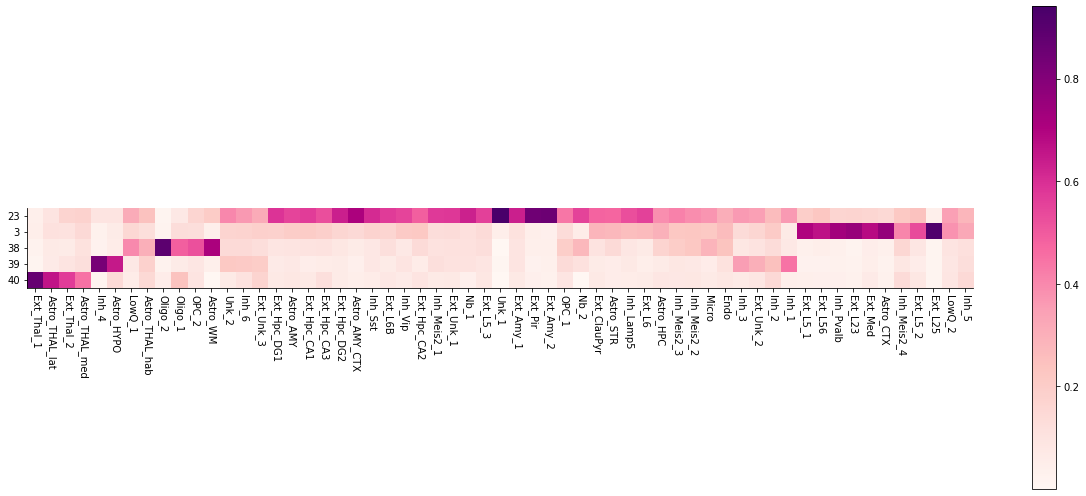

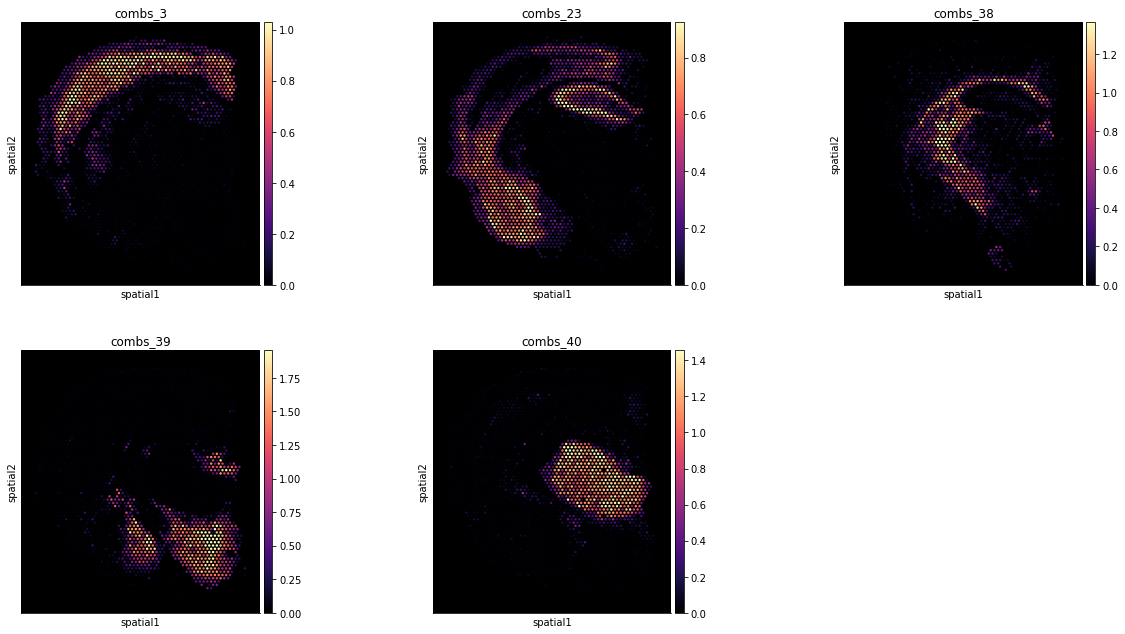

In [5]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis.uns['mod']['fact_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.037
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['combs_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['combs_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

s = 'spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(slide, cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

# read single cell data
adata_snrna_raw = anndata.read(f'{sc_results_folder}RegressionNBV2Torch_65covariates_40532cells_12819genes')
#adata_snrna_raw = anndata.read(f'{sc_results_folder}RegressionNBV2Torch_64covariates_40532cells_12819genes')

## Read saved sklearn neighbourhood model

In [6]:
# import models
def unpickle_model(path, mod_name):
    r""" Unpickle model
    """
    file = path + 'model_' + mod_name + ".p"
    
    mod1_ann = pickle.load(file = open(file, "rb"))
    return mod1_ann['mod']

n_fact = 18
mod_path = f'{results_folder}{run_name}/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/models/' 
adata_file = f'{results_folder}{run_name}/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/anndata/sp.h5ad' 


mod_sk = unpickle_model(mod_path, f'n_fact{n_fact}')

adata_vis_sk = anndata.read(adata_file)

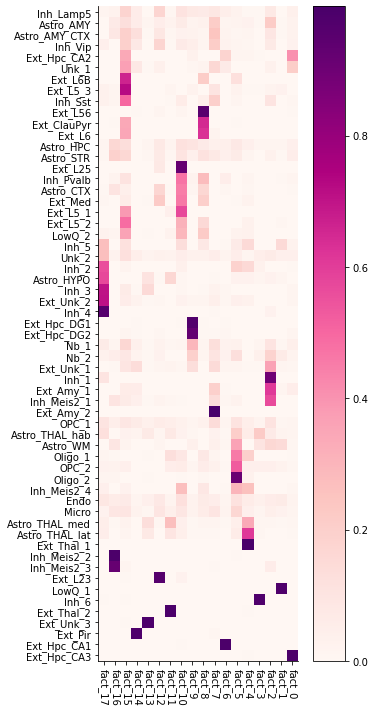

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/plots/figures/'

In [7]:
linkage = clustermap(mod_sk.cell_type_fractions,#.loc[b_dev_sel, fact_filt[::-1]],
           #cluster_rows=True, cluster_cols=True, 
           cluster_rows=True, cluster_cols=False, 
           figure_size=(5, 10), return_linkage=True, 
           fun_type='heatmap', array_size=None)

plt.savefig(f'{fig_path}/Fig3_brain_fact_dotplot.pdf', bbox_inches='tight')
plt.show()
fig_path

### Fig 3C

In [24]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.


GridSpec(3, 5, height_ratios=[1, 0.045, 0.045], width_ratios=[0.3, 3.5, 3.5, 3.5, 0.3])


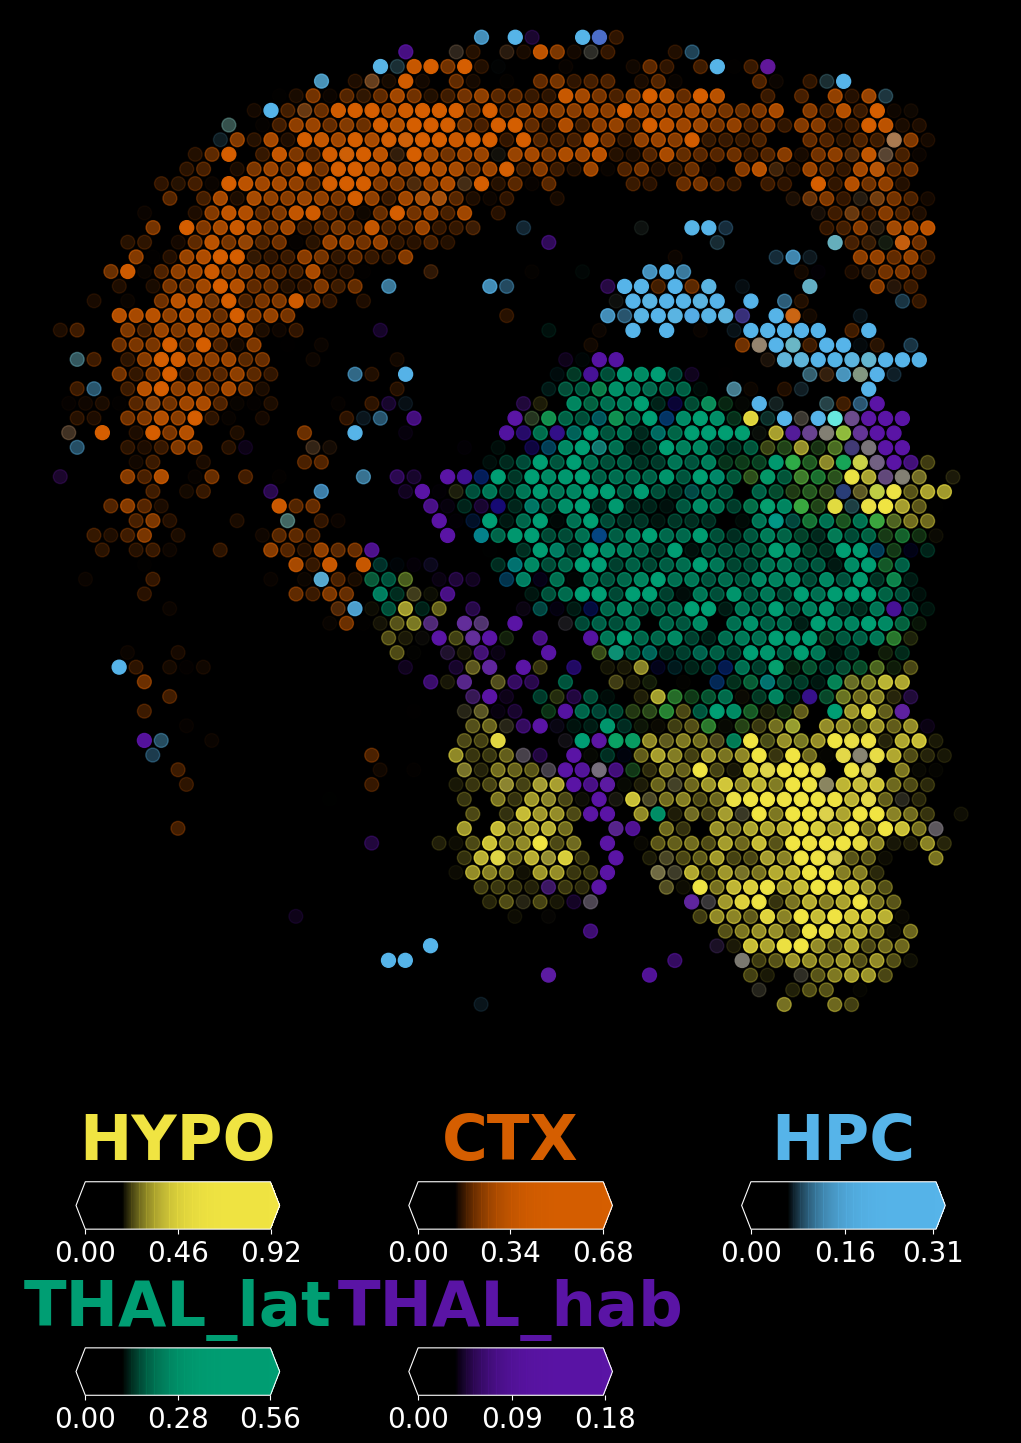

In [25]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 6 clusters 
sel_clust = ['Astro_HYPO','Astro_CTX','Astro_HPC','Astro_THAL_lat', 'Astro_THAL_hab']
sel_clust_lab = ['HYPO','CTX','HPC','THAL_lat', 'THAL_hab']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]
# s = 'ST8059048'

# slide = adata_vis[adata_vis.obs['sample']==s]
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (15,18)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=False, img_alpha=1,
                  #max_col=np.array((1, 1, 1, 1, 1, 1, 1)) * 0.7,
                  max_color_quantile=0.98, #reorder_cmap=[0,4],
              img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=10, alpha_scaling=1, labels=sel_clust_lab, 
                 style='dark_background', # fast dark_background
              crop_x=crop_x, crop_y=crop_y,
                 colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                 colorbar_shape={'vertical_gaps': 0.31, 'horizontal_gaps': 1, 
                                 'width': 3.5, 'height': 0.045},
                 colorbar_tick_size=20,
                )
    fig.savefig(f'{fig_path}Fig3C_multicell_maps.pdf',
                bbox_inches='tight', facecolor='black')

### Fig 3D

In [19]:
s2 = 'ST8059048'
s = f'spaceranger100_count_30458_{s2}_mm10-3_0_0_premrna'


adata_vis_sk.uns['spatial'].keys()

# Visualize cell type locations
# making copy to transform to log & assign nice names
adata_vis_pl = adata_vis_sk[adata_vis_sk.obs['sample'] == s2,:].copy()
clust_names_orig = ['q05_spot_factors' + i for i in adata_vis_pl.uns['mod']['fact_names']]
clust_names = adata_vis_pl.uns['mod']['fact_names']
adata_vis_pl.obs[clust_names] = (adata_vis_pl.obs[clust_names_orig])

# identify spot locations to crop near tissue
crop_max = (adata_vis_pl.obsm['spatial'] * list(adata_vis_pl.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
crop_min = (adata_vis_pl.obsm['spatial'] * list(adata_vis_pl.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

crop_x = [crop_min[0]-50, crop_max[0]+50]
crop_y = [crop_max[1]+20, crop_min[1]-20]

#max_y = list(adata_vis_pl.uns['spatial'].values())[0]['images']['hires'].shape[1]
#crop_y = [max_y - i + 80 for i in crop_y]

fact_names_orig = ['mean_nUMI_factors' + i for i in adata_vis_pl.uns[f'mod_coloc_n_fact{n_fact}']['fact_names']]
fact_names = adata_vis_pl.uns[f'mod_coloc_n_fact{n_fact}']['fact_names']
adata_vis_pl.obs[fact_names] = pd.DataFrame(adata_vis_pl.uns[f'mod_coloc_n_fact{n_fact}']['post_sample_means']['nUMI_factors'],
                                            index=adata_vis_pl.uns[f'mod_coloc_n_fact{n_fact}']['obs_names'],
                                            columns=fact_names)

#rcParams["axes.facecolor"] = "black"
#rcParams["savefig.facecolor"] = "white"
#rcParams["font.size"] = 24

crop_max, crop_min, crop_x, crop_y

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(array([1651.9231528, 1842.8002608]),
 array([249.9279112, 282.1059856]),
 [199.92791119999998, 1701.9231528],
 [1862.8002608, 262.1059856])

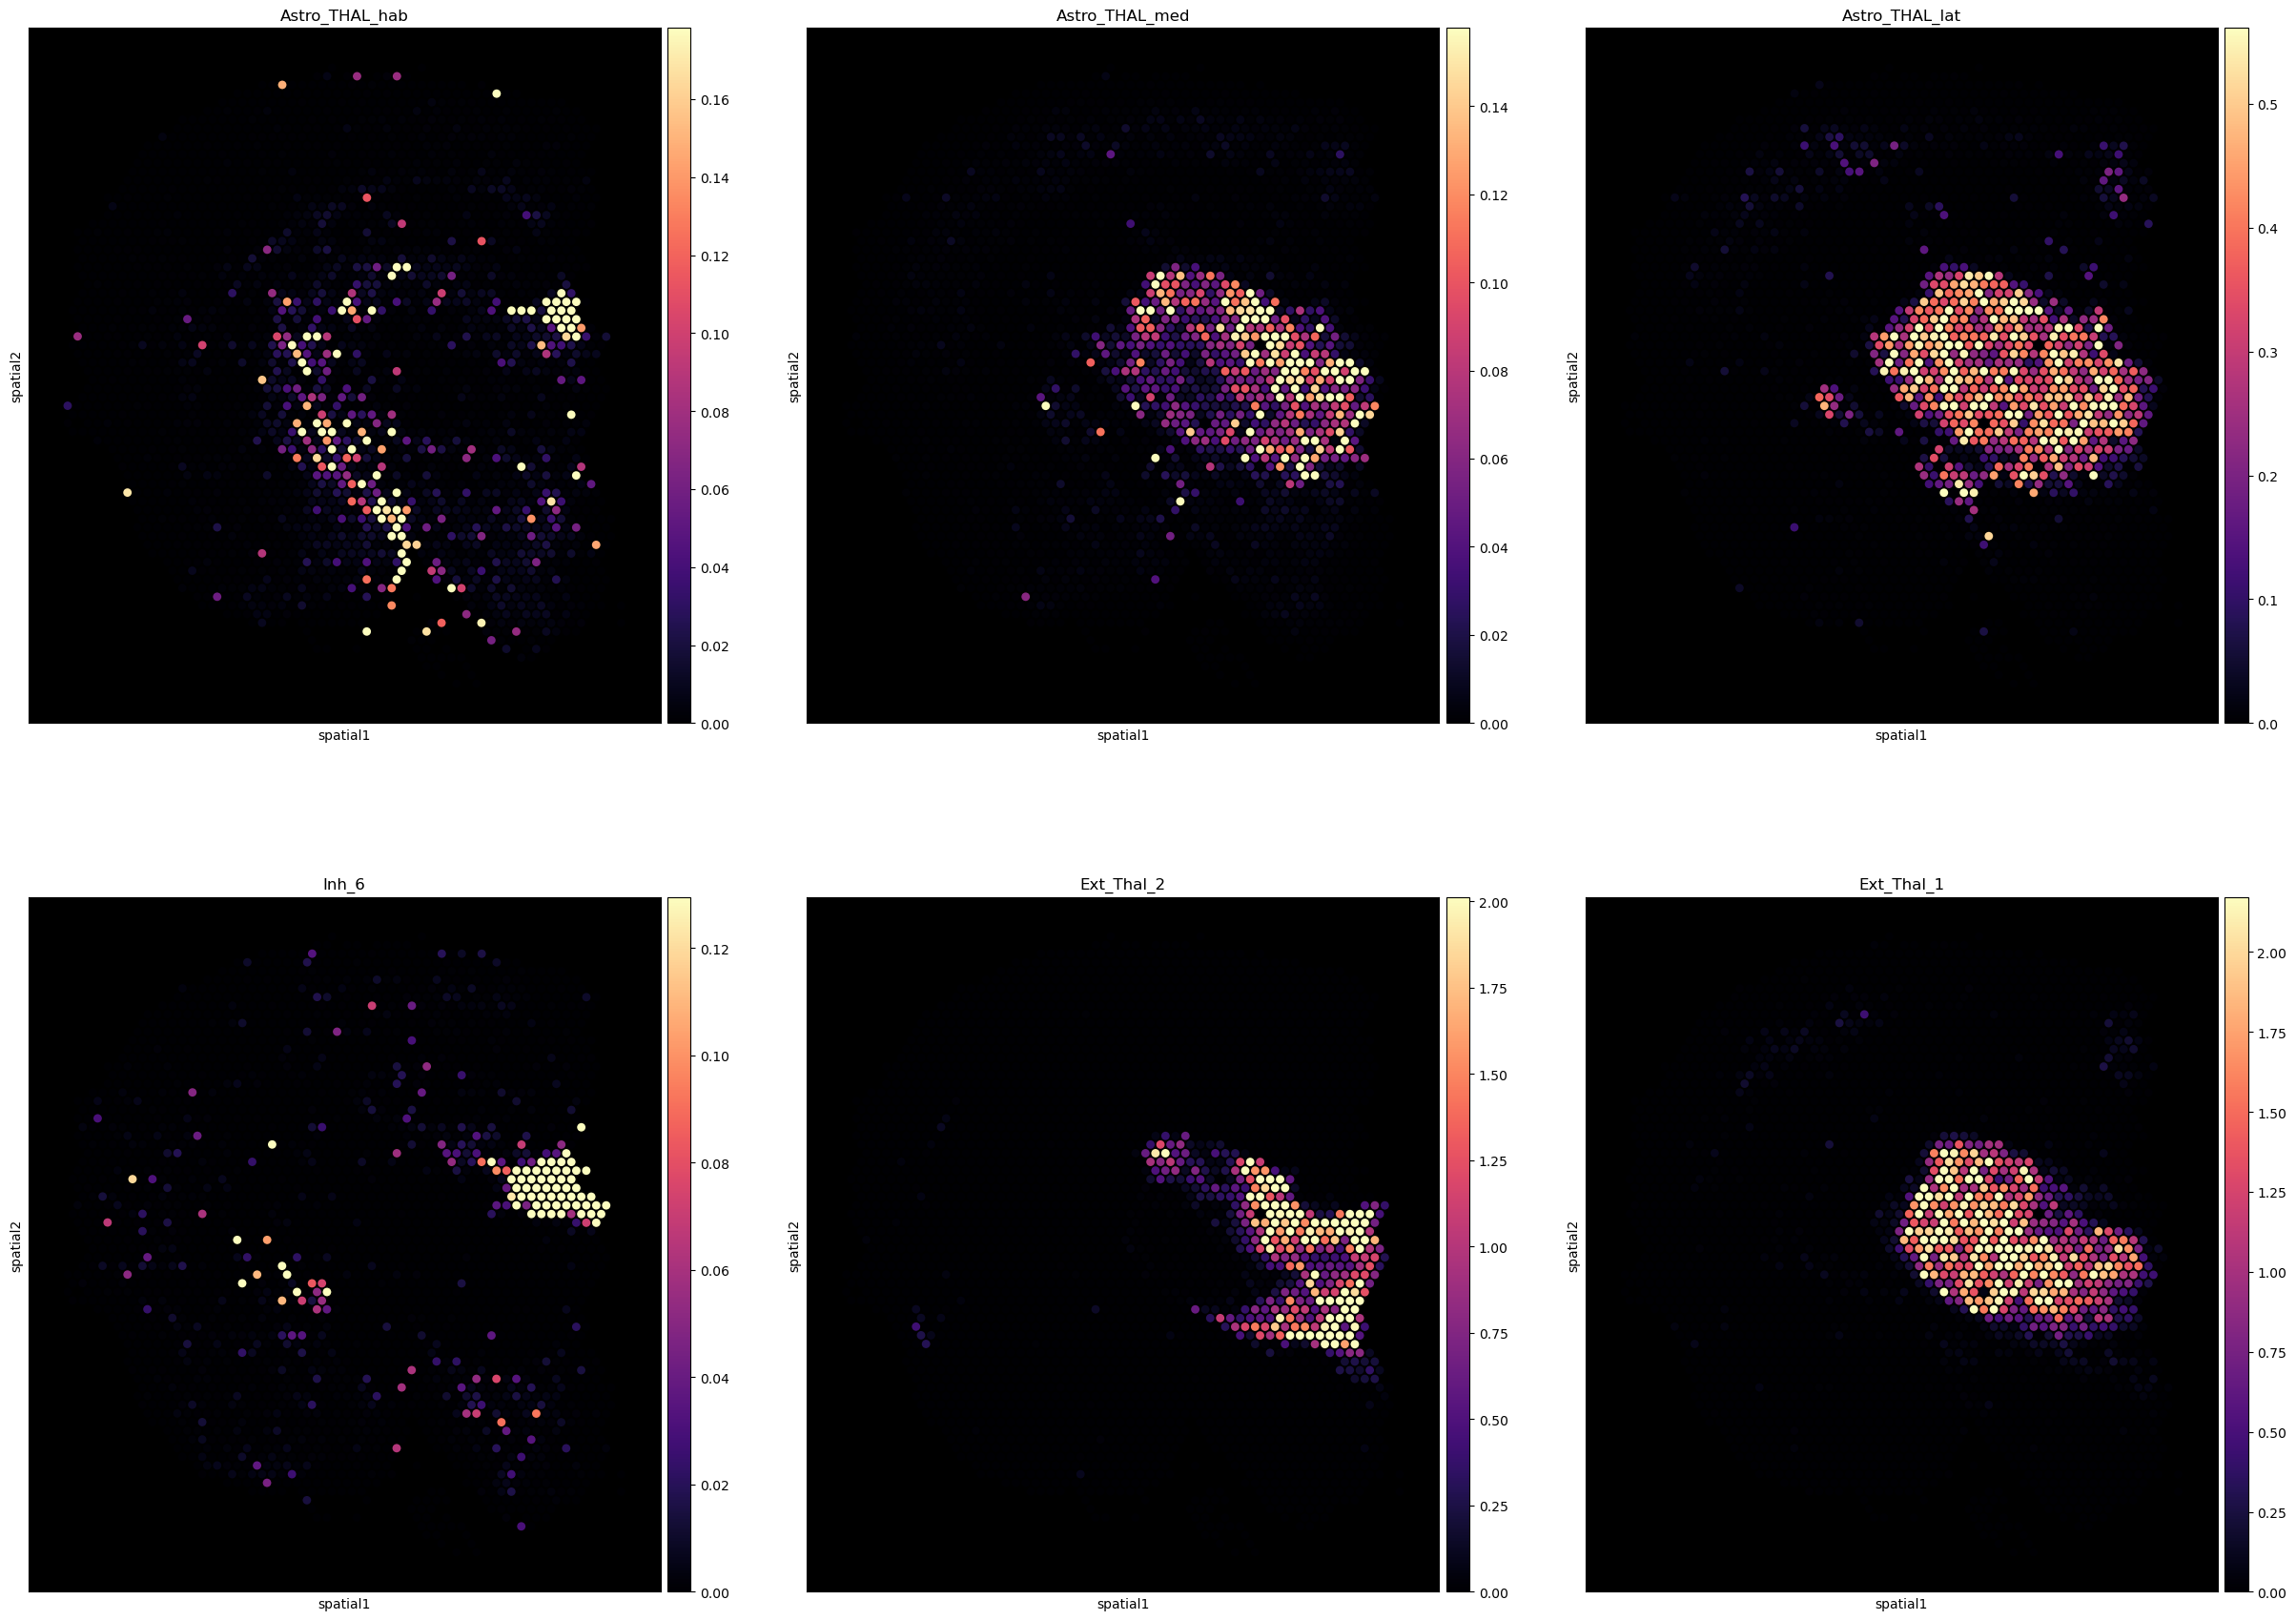

[199.92791119999998, 1701.9231528, 1706.8940144, 106.19973920000007]

In [20]:
ct_list=[
    'Astro_THAL_hab', 'Astro_THAL_med', 'Astro_THAL_lat', 
    'Inh_6', 'Ext_Thal_2','Ext_Thal_1'
]
# fix cropping coordinates (scanpy inverts them compared to cell2location)
y_size = list(slide.uns['spatial'].values())[0]['images']['hires'].shape[1]

with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [9, 10]}):
    sc.pl.spatial(adata_vis_pl, cmap='magma',
                  color=ct_list, ncols=3, 
                  library_id=s,
                  size=1.3, img_key='hires', alpha_img=0, alpha=1,
                  frameon=True, legend_fontsize=50,
                  #crop_coord=crop_x + [y_size-crop_y[1]] + [y_size-crop_y[0]],
                  vmin=0, vmax='p98', save=f'Fig3D_dot.pdf'
                 )

    #rcParams["figure.figsize"] = [15.5,8]
    #sc.pl.spatial(adata_vis_pl, cmap='magma',
    #              color=ct_list, ncols=3, 
    #              size=1.3, img_key='hires', alpha_img=0,
    #              frameon=True, legend_fontsize=50,
    #              crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
    #              vmin=0, vmax='p99.5', save=f'Fig7_D{ct_list[0]}_cropped.pdf',
    #              crop_coord=[710, 1260, 1850, 1450]
    #             )
crop_x + [y_size-crop_y[1]] + [y_size-crop_y[0]]

### Fig 3E

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'old_region' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'comments' as categorical


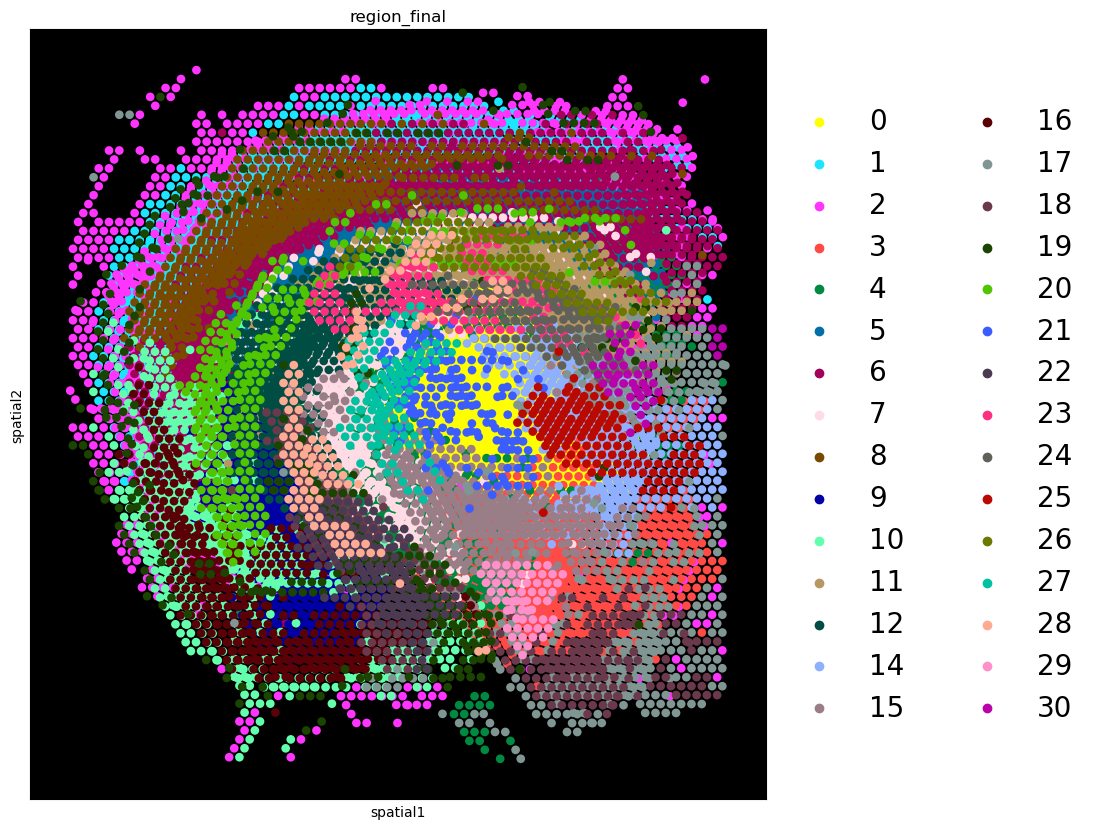

In [12]:
# Repeat clustering of regions to get matching number
# Cluster spots into regions using scanpy
#sc.tl.leiden(adata_vis_sk, resolution=0.52)
#adata_vis_sk.obs["region_cluster"] = adata_vis_sk.obs["leiden"]
#adata_vis_sk.obs["region_cluster"] = adata_vis_sk.obs["region_cluster"].astype("category")

adata_vis = adata_vis[adata_vis.obs['region_final'].astype('int').argsort(),:]
adata_vis.obs['region_final'] = adata_vis.obs['region_final'].astype('category')
cat_order = adata_vis.obs['region_final'].cat.categories.astype(int).sort_values().astype('str')
adata_vis.obs['region_final'].cat.reorder_categories(cat_order, inplace=True)
adata_vis.obs['location'] = adata_vis.obs['location'].astype('category')

s = 'ST8059048'
slide = select_slide(adata_vis, s)
crop_x, crop_y = get_crop_coord(slide)

with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):


    # Visualize cell type locations
    # making copy to transform to log & assign nice names
    sc.pl.spatial(adata_vis, #cmap='magma',
                  color=['region_final'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters.pdf',
                  palette=sc.pl.palettes.default_102
                 )

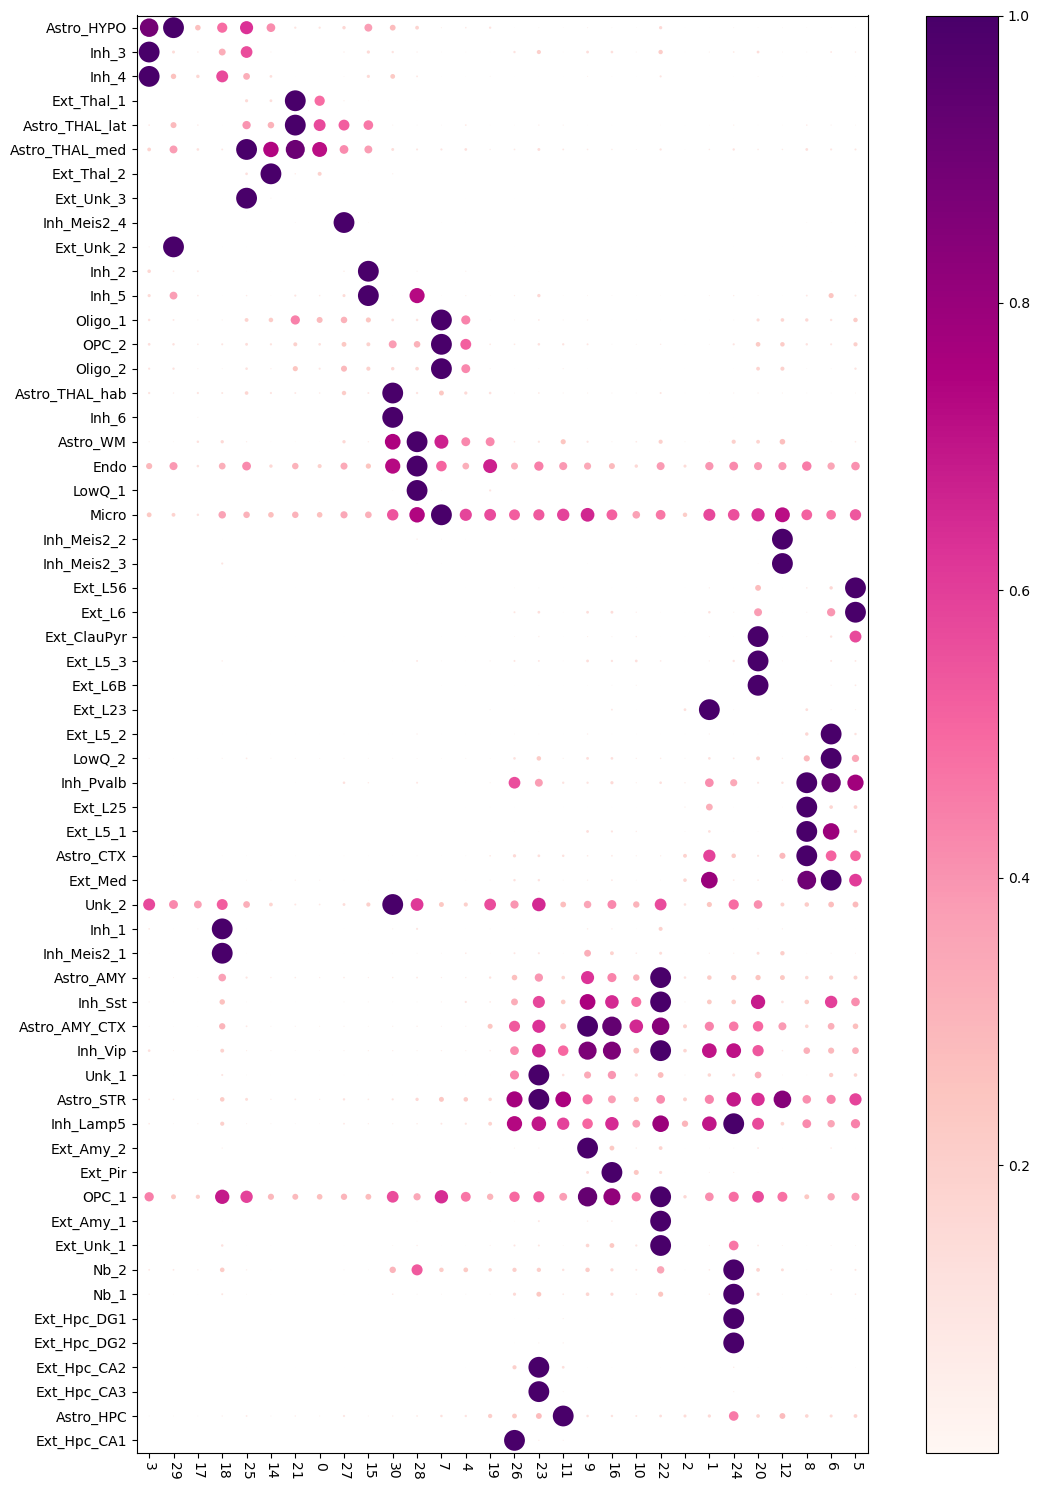

In [13]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap
#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["region_final"])
ct_aver.index = adata_vis.uns['mod']['fact_names']
#ct_aver.columns = ['region_' + c for c in ct_aver.columns]

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_final_clusters_dotplot.pdf',
                    bbox_inches='tight', facecolor='white')

#### Export the data to plot this heatmap in R

In [14]:
ct_aver = ct_aver.T
ct_aver['region_final'] = ct_aver.index

region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)

ct_aver['location'] = region_annot['location'][ct_aver.index]
ct_aver['subregion'] = region_annot['subregion'][ct_aver.index]
ct_aver['cortical_layer'] = region_annot['cortical_layer'][ct_aver.index]

ct_aver['region_final_colors'] = pd.Series(
    adata_vis.uns['region_final_colors'], 
    index=adata_vis.obs['region_final'].astype('category').cat.categories)[ct_aver.index]

ct_aver.to_csv(f'{sp_results_folder}{run_name}/20200904_region_cell_abundances.csv')
ct_aver

Astro_AMY  Astro_AMY_CTX  Astro_CTX  Astro_HPC  Astro_HYPO  Astro_STR  \
0    0.060235       0.045174   0.019728   0.047384    0.108795   0.060714   
1    0.218312       0.441211   0.591266   0.155904    0.017906   0.439974   
10   0.309164       0.654846   0.056038   0.094684    0.027176   0.257348   
11   0.174394       0.289030   0.118276   1.000000    0.030346   0.754343   
12   0.236073       0.384898   0.293271   0.283169    0.033505   0.845916   
14   0.065058       0.043587   0.018355   0.043776    0.417353   0.060491   
15   0.058886       0.038686   0.023188   0.045704    0.378463   0.078898   
16   0.437048       0.931211   0.080874   0.114551    0.033524   0.378302   
17   0.035402       0.025237   0.012449   0.034281    0.267876   0.048235   
18   0.368252       0.303647   0.026327   0.059300    0.488552   0.219822   
19   0.116018       0.242474   0.078422   0.207183    0.112363   0.170158   
2    0.121267       0.191551   0.187169   0.146897    0.010732   0.188575   
20   0.254186       0.500352   0.101939   0.175885    0.031356   0.638398   
21   0.074430       0.050805   0.027192   0.064774    0.108045   0.082809   
22   1.000000       0.843033   0.060797   0.131957    0.157516   0.420687   
23   0.397840       0.631217   0.131811   0.280952    0.038335   1.000000   
24   0.254448       0.460245   0.218757   0.460289    0.040871   0.695259   
25   0.105489       0.084597   0.029946   0.083278    0.629694   0.142671   
26   0.267152       0.531982   0.157348   0.230534    0.023894   0.771401   
27   0.076788       0.052684   0.029060   0.100875    0.164958   0.114080   
28   0.085751       0.063320   0.029123   0.081460    0.182436   0.161475   
29   0.047605       0.028067   0.016669   0.033090    1.000000   0.072297   
3    0.058744       0.035265   0.014626   0.037563    0.887927   0.078301   
30   0.070590       0.053001   0.017001   0.064719    0.278065   0.102458   
4    0.064045       0.050766   0.032637   0.112783    0.076726   0.218153   
5    0.191104       0.269796   0.509337   0.181534    0.024874   0.587154   
6    0.202031       0.323937   0.514487   0.147926    0.026186   0.439649   
7    0.058971       0.047164   0.020251   0.119891    0.053324   0.238968   
8    0.171190       0.173691   1.000000   0.173750    0.028253   0.412907   
9    0.628609       1.000000   0.076330   0.120900    0.048665   0.481061   

    Astro_THAL_hab  Astro_THAL_lat  Astro_THAL_med  Astro_WM  ...     OPC_2  \
0         0.073032        0.572326        0.717650  0.022707  ...  0.127352   
1         0.028266        0.027754        0.072279  0.027920  ...  0.038767   
10        0.036059        0.012119        0.039392  0.078535  ...  0.042183   
11        0.050714        0.052948        0.088584  0.247172  ...  0.110856   
12        0.051974        0.029262        0.070248  0.269810  ...  0.217397   
14        0.102561        0.313235        0.740580  0.028698  ...  0.108875   
15        0.092830        0.463189        0.379912  0.066837  ...  0.190623   
16        0.048459        0.018671        0.070095  0.048662  ...  0.036470   
17        0.103491        0.070650        0.126574  0.120437  ...  0.079154   
18        0.094572        0.020130        0.091466  0.159570  ...  0.099243   
19        0.125057        0.023488        0.062019  0.428012  ...  0.080519   
2         0.016387        0.011419        0.027252  0.045923  ...  0.017904   
20        0.058763        0.021917        0.076113  0.182565  ...  0.224075   
21        0.089784        1.000000        0.914045  0.030678  ...  0.192094   
22        0.097285        0.030275        0.108416  0.200722  ...  0.065762   
23        0.081088        0.060837        0.139289  0.106166  ...  0.122482   
24        0.053693        0.057875        0.113629  0.201148  ...  0.102289   
25        0.175715        0.399310        1.000000  0.061211  ...  0.137265   
26        0.036061        0.029691        0.080639  0.079313  ...  0.078402   
27        0.211741        0.523630  

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'old_region' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'comments' as categorical


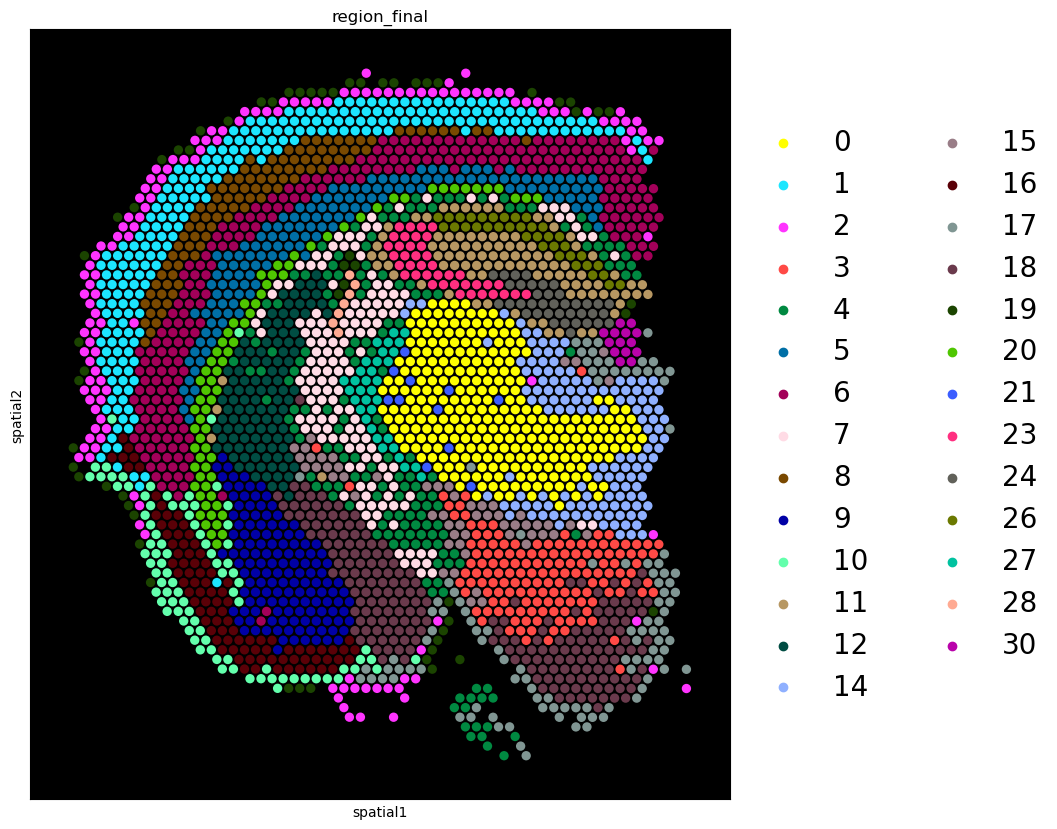

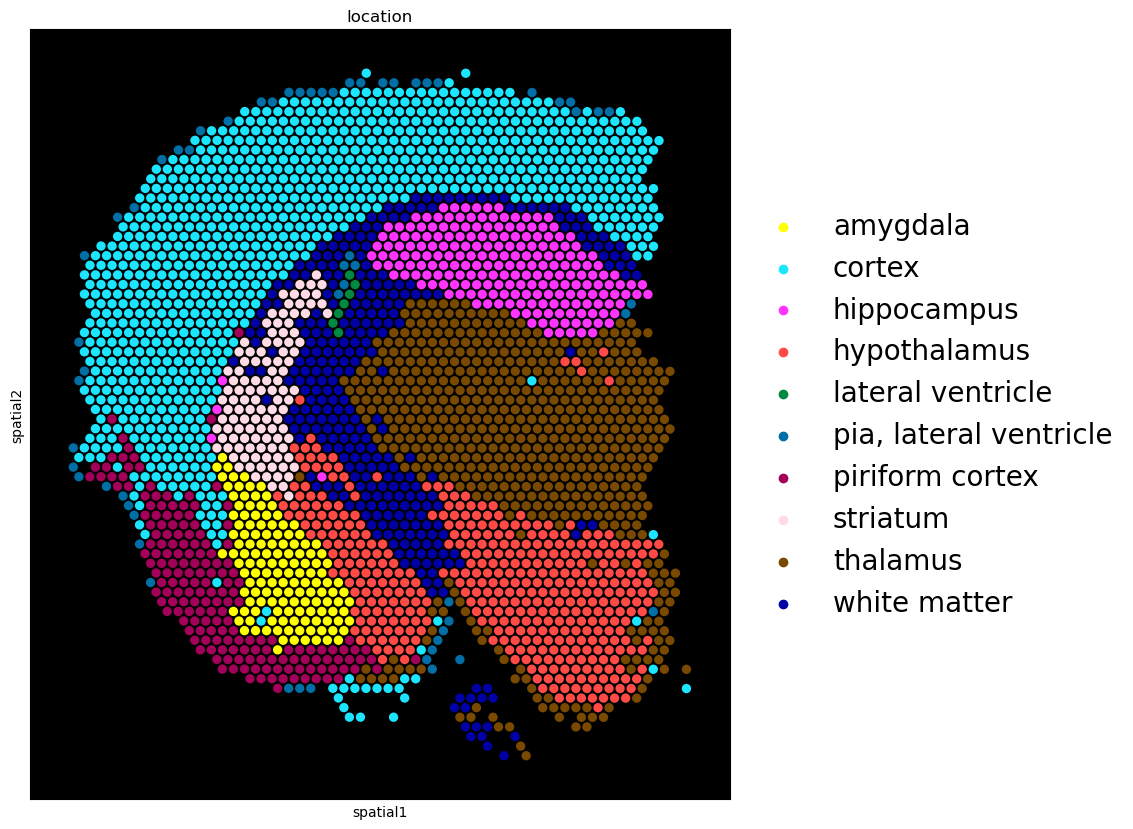

In [15]:
with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):
    
    sel_clust = adata_vis.obs['region_final'].cat.categories.isin(slide.obs['region_final'].cat.categories)
    slide.uns['region_final_colors'] = list(np.array(adata_vis.uns['region_final_colors'])[sel_clust])
    sc.pl.spatial(slide, #cmap='magma',
                  color=['region_final'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters.pdf',
                  #palette=sc.pl.palettes.default_102
                 )
    
    sc.pl.spatial(slide, #cmap='magma',
                  color=['location'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_suppl_2D_broad_locations.pdf',
                  palette=sc.pl.palettes.default_102
                 )

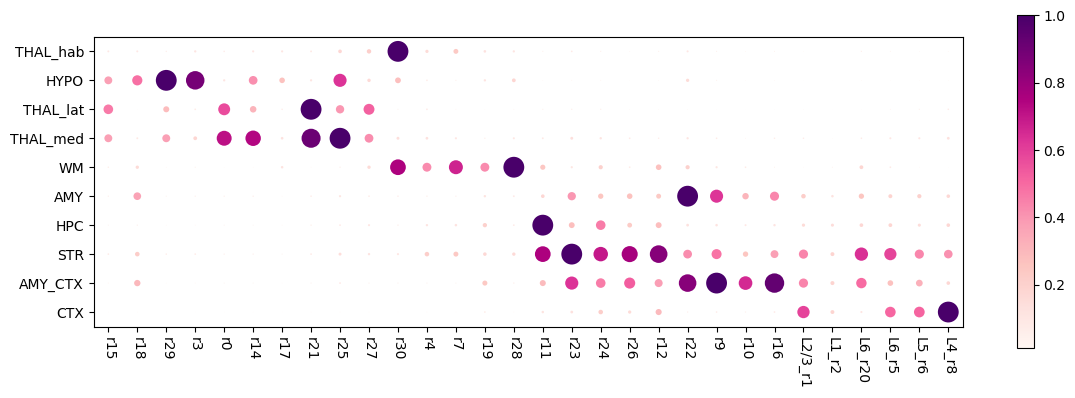

In [16]:
# load order of clusters and regions from R
ct_aver = pd.read_csv(f'{str(sc.settings.figdir)}/Fig3E_astro_location_pheatmap.csv',
                      index_col=0)
ct_aver = ct_aver[ct_aver.columns[::-1]]

with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=False, cluster_cols=False, figure_size=(12, 4), equal=True)
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_final_clusters_astro_dotplot.pdf',
                    bbox_inches='tight', facecolor='white')

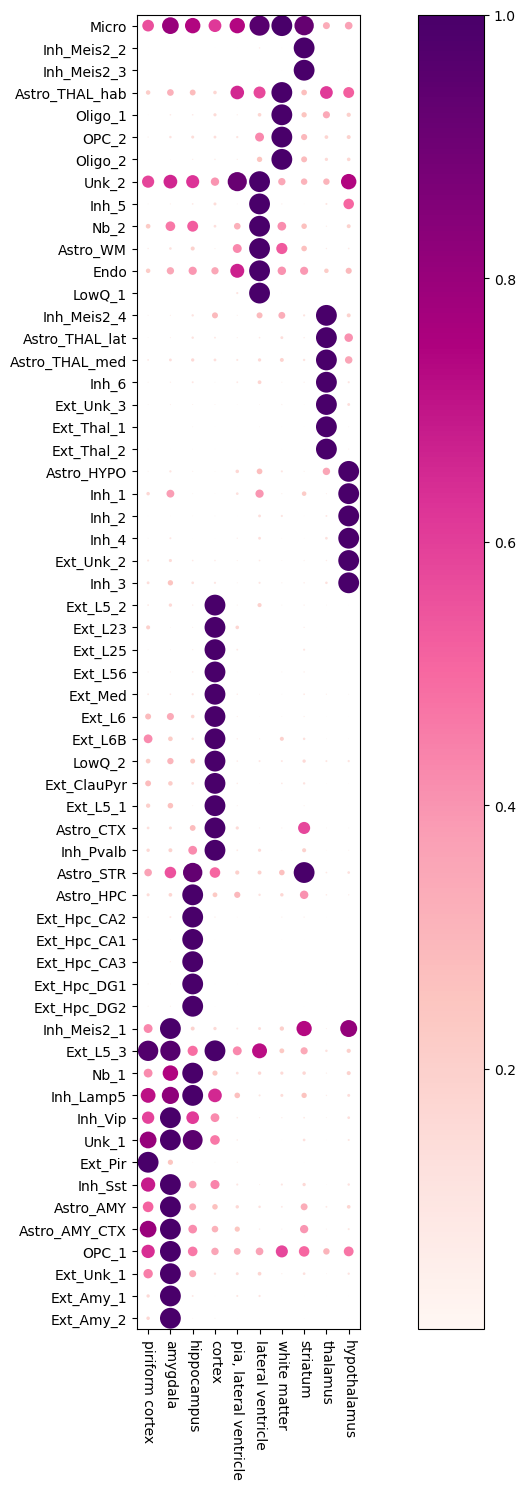

In [17]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap
#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["location"])
ct_aver.index = adata_vis.uns['mod']['fact_names']
ct_aver.columns = ct_aver.columns

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_location_dotplot.pdf',
                    bbox_inches='tight', facecolor='white')